In [ ]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 209 kB 11.6 MB/s 
     |████████████████████████████████| 81 kB 1.2 MB/s 
     |████████████████████████████████| 78 kB 993 kB/s 
     |████████████████████████████████| 49 kB 3.5 MB/s 
     |████████████████████████████████| 112 kB 39.7 MB/s 
     |████████████████████████████████| 146 kB 36.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=3ad9d81bc21c40266fac05fe29859e620a0e2cf3f0cf0cc901043c442644a200
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from scipy.optimize import minimize
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from tqdm.notebook import tqdm
from lightgbm import LGBMRegressor, LGBMClassifier
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import joblib

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def encode_data(data, type_enc='ord'):
    df = data.copy()
    if type_enc == 'ohe':
        df['month'] = df['month'].astype(object)
        df['year'] = df['year'].astype(object)
        categorical = ['ticker', 'ind_template', 'REIT', 'month', 'year', 'Industry']
        cat_enc = pd.get_dummies(df[categorical])
        cat_enc_feat = cat_enc.columns + ['isDirect']
        df_full = pd.concat([cat_enc, df.drop(categorical, axis=1)], axis=1)
    elif type_enc == 'ord':
        categorical = ['ticker', 'ind_template', 'REIT', 'Industry']
        ord = OrdinalEncoder()
        cat_enc = pd.DataFrame(ord.fit_transform(df[categorical]), columns=categorical)
        cat_enc_feat = cat_enc.columns + ['isDirect']
        df_full = pd.concat([cat_enc, df.drop(categorical, axis=1)], axis=1)

    return df_full, cat_enc_feat


In [ ]:
def optimize_lgbm_clf(X, y, n_trials=100):
    def objective(trial):
        params = {
            'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
            'min_data_in_bin': trial.suggest_int('min_data_in_bin', 1, 256),
            'min_split_gain': trial.suggest_discrete_uniform('min_split_gain', 0.1, 5, 0.01),
            'max_depth': trial.suggest_int('max_depth', 1, 9),
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
            'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
            'max_bin': trial.suggest_int('max_bin', 32, 255),
            'random_state': 19,
            'class_weight': 'balanced',
        }

        cv = TimeSeriesSplit(n_splits=5)
        model = LGBMClassifier(**params)
        base_scoring = 'roc_auc'
        scores = cross_val_score(model, X, y, cv=cv, scoring=base_scoring, verbose=False)
        score = np.mean(scores)

        return score

    sampler = TPESampler(seed=19)
    study = create_study(direction='maximize', study_name="LGBM Classifier", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    plot_optimization_history(study)
    plot_param_importances(study)
    plt.show()
    best_pars_mass = study.best_params
    print(f'Best score: {study.best_value}')
    return best_pars_mass


def optimize_rf_clf(X, y, n_trials=100):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'n_jobs': -1,
            'random_state': 19,
        }

        cv = TimeSeriesSplit(n_splits=5)
        model = RandomForestClassifier(**params)
        base_scoring = 'roc_auc'
        scores = cross_val_score(model, X, y, cv=cv, scoring=base_scoring, verbose=False)
        score = np.mean(scores)

        return score

    sampler = TPESampler(seed=19)
    study = create_study(direction='maximize', study_name="RF Classifier", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    plot_optimization_history(study)
    plot_param_importances(study)
    plt.show()
    best_pars_mass = study.best_params
    print(f'Best score {study.best_value}')
    return best_pars_mass

    
def optimize_logreg(X, y, n_trials=100):
    def objective(trial):
        params = {'solver': trial.suggest_categorical("solver", ["admm", "gradient_descent", "proximal_grad"]),
                  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
                  'C': trial.suggest_float("C", 1e-10, 1e10, log=True),
                  'random_state': 19
        }

        cv = TimeSeriesSplit(n_splits=5)
        model = LogisticRegression(**params)
        base_scoring = 'roc_auc'
        scores = cross_val_score(model, X, y, cv=cv, scoring=base_scoring, verbose=False)
        score = np.mean(scores)

        return score

    sampler = TPESampler(seed=19)
    study = create_study(direction='maximize', study_name="LR Classifier", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    plot_optimization_history(study)
    plot_param_importances(study)
    plt.show()
    best_pars_mass = study.best_params
    print(f'Best score {study.best_value}')
    return best_pars_mass

In [ ]:
def optimize_lgbm_regr(X, y, n_trials=100):
    def objective(trial):
        params = {
            'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
            'min_data_in_bin': trial.suggest_int('min_data_in_bin', 1, 256),
            'min_split_gain': trial.suggest_discrete_uniform('min_split_gain', 0.1, 5, 0.01),
            'max_depth': trial.suggest_int('max_depth', 1, 9),
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
            'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
            'max_bin': trial.suggest_int('max_bin', 32, 255),
            'random_state': 19,
            'class_weight': 'balanced',
        }

        cv = TimeSeriesSplit(n_splits=5)
        model = LGBMRegressor(**params)
        base_scoring = 'neg_mean_absolute_error'
        scores = cross_val_score(model, X, y, cv=cv, scoring=base_scoring, verbose=False)
        score = np.mean(scores)

        return score

    sampler = TPESampler(seed=19)
    study = create_study(direction='maximize', study_name="LGBM Regressor", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_pars_mass = study.best_params
    print(f'Best score: {study.best_value}')
    return best_pars_mass


def optimize_rf_regr(X, y, n_trials=100):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'n_jobs': -1,
            'random_state': 19,
        }

        cv = TimeSeriesSplit(n_splits=5)
        model = RandomForestRegressor(**params)
        base_scoring = 'neg_mean_absolute_error'
        scores = cross_val_score(model, X, y, cv=cv, scoring=base_scoring, verbose=False)
        score = np.mean(scores)

        return score

    sampler = TPESampler(seed=19)
    study = create_study(direction='maximize', study_name="RF Regressor", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_pars_mass = study.best_params
    print(f'Best score {study.best_value}')
    return best_pars_mass

In [ ]:
def train_oot_split(df, target_col, y=1):
    targets = df.columns[-15:-1]
    drop_targets = targets.drop(target_col)
    to_drop = ['price', 'period']
    df = df.drop(drop_targets, axis=1).dropna().sort_values('period').reset_index(drop=True)
    periods = np.sort(df['period'].unique())[-12*y:]
    train = df[~df['period'].isin(periods)].drop(to_drop, axis=1)
    test = df[df['period'].isin(periods)].drop(to_drop, axis=1)
    X_train, y_train =  train.drop(target_col, axis=1), train[target_col]
    X_oot, y_oot =  test.drop(target_col, axis=1), test[target_col]
    del df
    return X_train, y_train, X_oot, y_oot


In [ ]:
def select_features_using_corr(X, y, n=100):
    print("Start select features by correlation")
    correlations = dict()
    for feature in tqdm(X.columns):
        correlations[feature] = X[feature].corr(y)
    feature_corrs = sorted(correlations.items(), key=lambda item: item[1], reverse=True)
    return pd.Index(dict(feature_corrs[:n]).keys())

def select_features_using_score(X_train, y_train, X_oot, y_oot, n=100):
    scores = dict()
    print("Start select features by score")
    for feature in tqdm(X_train.columns):
        model = DecisionTreeClassifier(random_state=19)
        model.fit(X_train[[feature]], y_train)
        scores[feature] = roc_auc_score(y_oot, model.predict_proba(X_oot[[feature]])[:,1])
    feature_scores = sorted(scores.items(), key=lambda item: item[1], reverse=True)
    return pd.Index(dict(feature_scores[:n]).keys())

def select_features(X_train, y_train, X_oot, y_oot, n=100):
    features_corr = select_features_using_corr(X_train, y_train, n)
    features_score = select_features_using_score(X_train, y_train, X_oot, y_oot, n)
    # features_all = pd.Index(list(set(features_corr) & set(features_score)))
    features_any = pd.Index(list(set(features_corr) | set(features_score)))
    print(f'Отобрано признаков: {features_any.size}')
    return features_any

In [ ]:
def fit_and_save_models(df_gross):
    df_gross['period'] = pd.to_datetime(df_gross['period'])

    targets = df_gross.columns[-34:-1]
    ratio = df_gross[targets].mean()
    bad_targets = list(set(ratio[:-3][ratio[:-3] < 0.01].index) | set(df_gross.columns[-14:-1]))
    targets = sorted(list(set(targets) - set(bad_targets)))
    df_gross = df_gross.drop(bad_targets, axis=1)

    df_full, categorical = encode_data(df_gross, 'ord')
    selected_features = dict() 
    print(targets)
    for i, target_col in enumerate(targets[1:]):
        print(f'Tuning {target_col} model')
        X_train, y_train, X_oot, y_oot = train_oot_split(df_full, target_col)

        features = select_features(X_train, y_train, X_oot, y_oot)
        pd.DataFrame({target_col: features}).to_csv(f'/content/drive/MyDrive/course_models/features_{target_col}.csv', index=False)

        best_params_lgbm = optimize_lgbm_clf(X_train[features], y_train, 10)
        lgbm = LGBMClassifier(**best_params_lgbm)
        lgbm.fit(X_train[features], y_train)
        lgbm.booster_.save_model(f'/content/drive/MyDrive/course_models/{target_col}_lgbm_model.txt')

        y_train_pred_lgbm = lgbm.predict_proba(X_train[features])[:,1]
        y_oot_pred_lgbm = lgbm.predict_proba(X_oot[features])[:,1]
        print(f'ROC-AUC train: {roc_auc_score(y_train, y_train_pred_lgbm)}')
        print(f'ROC-AUC oot: {roc_auc_score(y_oot, y_oot_pred_lgbm)}')

        # best_params_lr = optimize_logreg(X_train[features], y_train, 10)
        # logreg = LogisticRegression(**best_params_lr)
        # logreg.fit(X_train[features], y_train)
        # joblib.dump(logreg, f'/content/drive/MyDrive/course_models/{target_col}_logreg_model.txt')

        # best_params_rf = optimize_rf_clf(X_train, y_train, 20)
        # rf = RandomForestClassifier(**best_params_rf)
        # rf.fit(X_train, y_train)
        # joblib.dump(rf, f'/content/drive/MyDrive/course_models/{target_col}_logreg_model.txt')

        print(f'Saved {target_col} model')
        
        del X_train, y_train, X_oot, y_oot
        del lgbm, features, best_params_lgbm

In [ ]:
df_gross = pd.read_csv('/content/drive/MyDrive/gross_simple_return_data.csv')
# df_gross = pd.read_csv('gross_simple_return_data.csv')

In [ ]:
df_gross.head(50)

,ticker,period,ind_template,REIT,isDirect,Revenue per Share,Earnings per Share (Diluted),EPS without NRI,Owner Earnings per Share (TTM),Free Cash Flow per Share,...,return_2Y_more_0.25,return_2Y_less_-0.25,return_2Y_more_0.5,return_2Y_less_-0.5,return_3Y_more_0.6,return_3Y_less_-0.6,return_1Y,return_2Y,return_3Y,price
0,AAL,2005-12-01,N,N,1,79.612,-9.639,-9.639,-3.918,-1.587,...,0,1,0,1,0,1,0.652843,-0.519364,-0.801457,34.842381
1,AAL,2006-01-01,N,N,0,79.612,-9.639,-9.639,-3.918,-1.587,...,0,1,0,1,0,1,0.698652,-0.626574,-0.762567,33.521000
2,AAL,2006-02-01,N,N,0,79.612,-9.639,-9.639,-3.918,-1.587,...,0,1,0,1,0,1,0.797181,-0.543785,-0.855859,31.555263
3,AAL,2006-03-01,N,N,1,76.205,-1.312,-1.312,-1.223,9.768,...,0,1,0,1,0,1,0.370473,-0.725774,-0.925705,35.350435
4,AAL,2006-04-01,N,N,0,76.205,-1.312,-1.312,-1.223,9.768,...,0,1,0,1,0,1,0.130533,-0.785124,-0.909307,39.610526
5,AAL,2006-05-01,N,N,0,76.205,-1.312,-1.312,-1.223,9.768,...,0,1,0,1,0,1,-0.268021,-0.855841,-0.925520,47.153636
6,AAL,2006-06-01,N,N,1,62.670,3.052,3.052,2.773,7.143,...,0,1,0,1,0,1,-0.343156,-0.928517,-0.943452,46.677728
7,AAL,2006-07-01,N,N,0,62.670,3.052,3.052,2.773,7.143,...,0,1,0,1,0,1,-0.327975,-0.937449,-0.953453,50.838500
8,AAL,2006-08-01,N,N,0,62.670,3.052,3.052,2.773,7.143,...,0,1,0,1,0,1,-0.297396,-0.822460,-0.924657,41.973044
9,AAL,2006-09-01,N,N,1,62.618,0.161,0.161,11.350,0.161,...,0,1,0,1,0,1,-0.334910,-0.830620,-0.903791,44.481500


['target_less_-0.01_in_1_quart_along', 'target_less_-0.01_in_2_quart_along', 'target_less_-0.01_in_4_quart_along', 'target_less_-0.01_in_6_quart_along', 'target_less_-0.05_in_1_quart_along', 'target_less_-0.05_in_2_quart_along', 'target_less_-0.05_in_4_quart_along', 'target_more_0.01_in_1_quart_along', 'target_more_0.01_in_2_quart_along', 'target_more_0.01_in_4_quart_along', 'target_more_0.01_in_6_quart_along', 'target_more_0.05_in_1_quart_along', 'target_more_0.05_in_2_quart_along', 'target_more_0.05_in_4_quart_along']
Tuning target_less_-0.01_in_2_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 181


[I 2022-06-22 07:56:28,045] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 07:58:13,792] Trial 0 finished with value: 0.6092227579482545 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.6092227579482545.
[I 2022-06-22 08:00:24,636] Trial 1 finished with value: 0.6061681105641328 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 0 with value: 0.609

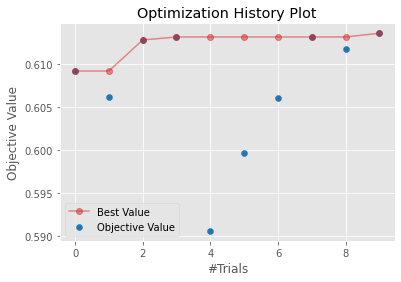

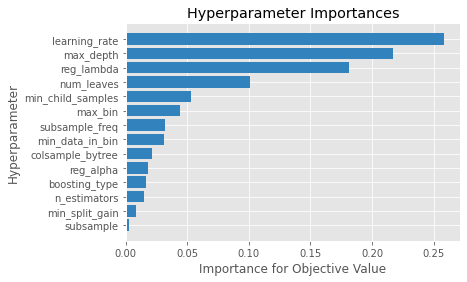

Best score: 0.613624323800978
ROC-AUC train: 0.648541833397519
ROC-AUC oot: 0.7326100151603672
Saved target_less_-0.01_in_2_quart_along model
Tuning target_less_-0.01_in_4_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 175


[I 2022-06-22 08:36:31,368] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 08:38:09,712] Trial 0 finished with value: 0.6772593672541559 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.6772593672541559.
[I 2022-06-22 08:40:12,593] Trial 1 finished with value: 0.6652330637068695 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 0 with value: 0.677

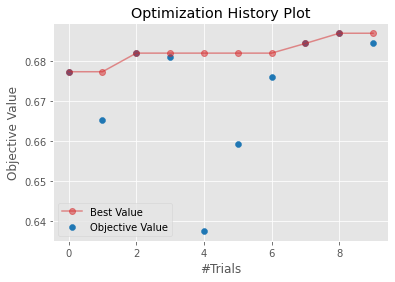

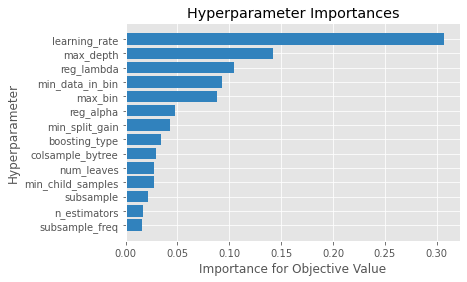

Best score: 0.6868691152048096
ROC-AUC train: 0.7114289729869626
ROC-AUC oot: 0.7972794557139244
Saved target_less_-0.01_in_4_quart_along model
Tuning target_less_-0.01_in_6_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 174


[I 2022-06-22 09:14:37,782] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 09:16:14,355] Trial 0 finished with value: 0.7134051639673927 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.7134051639673927.
[I 2022-06-22 09:18:13,330] Trial 1 finished with value: 0.6835669320986599 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 0 with value: 0.713

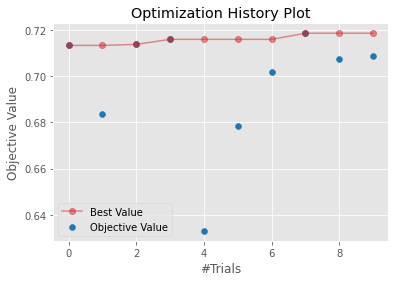

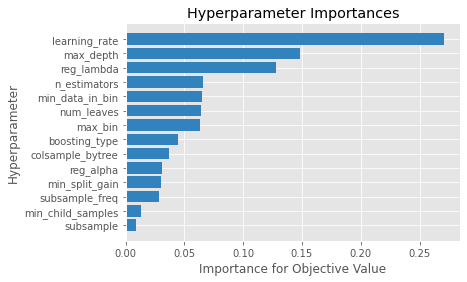

Best score: 0.7186817429823845
ROC-AUC train: 0.24129226145123228
ROC-AUC oot: 0.16985395399739608
Saved target_less_-0.01_in_6_quart_along model
Tuning target_less_-0.05_in_1_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 182


[I 2022-06-22 09:53:33,837] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 09:55:21,794] Trial 0 finished with value: 0.6026223334752295 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.6026223334752295.
[I 2022-06-22 09:57:36,323] Trial 1 finished with value: 0.6133928480407442 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 1 with value: 0.613

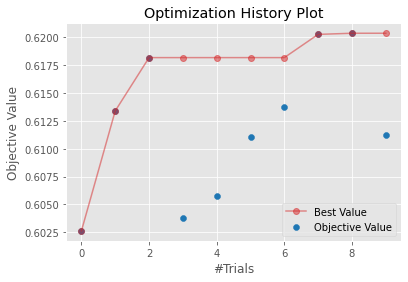

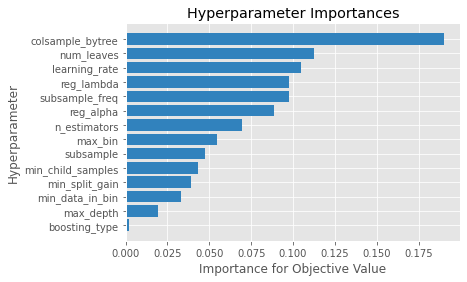

Best score: 0.6203629779488298
ROC-AUC train: 0.652817454763944
ROC-AUC oot: 0.7096489631324522
Saved target_less_-0.05_in_1_quart_along model
Tuning target_less_-0.05_in_2_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 181


[I 2022-06-22 10:32:15,056] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 10:34:04,043] Trial 0 finished with value: 0.664731246132148 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.664731246132148.
[I 2022-06-22 10:36:16,481] Trial 1 finished with value: 0.6652930406558202 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 1 with value: 0.66529

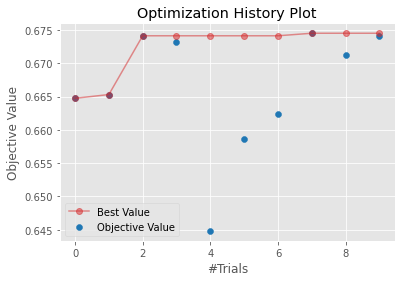

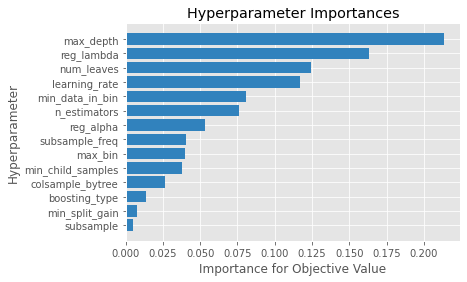

Best score: 0.6744939657251884
ROC-AUC train: 0.6988712298449639
ROC-AUC oot: 0.779427838014046
Saved target_less_-0.05_in_2_quart_along model
Tuning target_less_-0.05_in_4_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 176


[I 2022-06-22 11:14:06,660] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 11:15:46,075] Trial 0 finished with value: 0.7551386011952843 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.7551386011952843.
[I 2022-06-22 11:17:53,486] Trial 1 finished with value: 0.736626841221224 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 0 with value: 0.7551

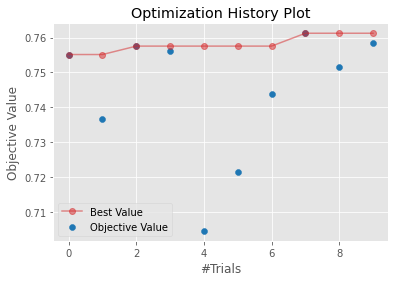

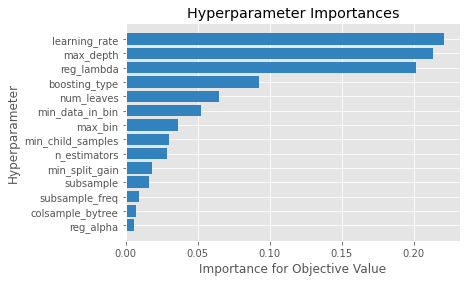

Best score: 0.7612232972371104
ROC-AUC train: 0.7490460717914977
ROC-AUC oot: 0.8634426063482419
Saved target_less_-0.05_in_4_quart_along model
Tuning target_more_0.01_in_1_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 186


[I 2022-06-22 11:56:18,529] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 11:58:14,429] Trial 0 finished with value: 0.5801900182830184 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.5801900182830184.
[I 2022-06-22 12:00:27,388] Trial 1 finished with value: 0.5748761291188311 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 0 with value: 0.580

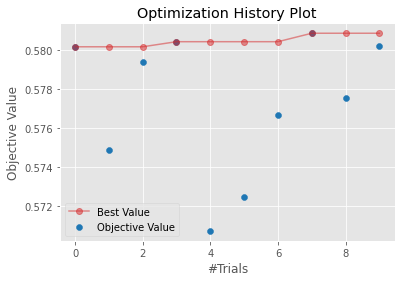

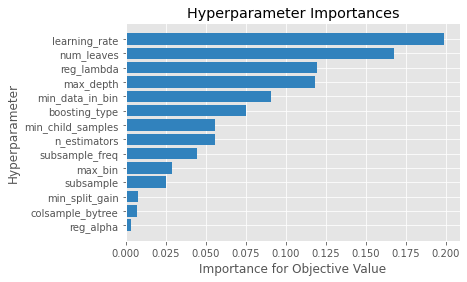

Best score: 0.5808849658045863
ROC-AUC train: 0.6204760588162905
ROC-AUC oot: 0.6421878078408785
Saved target_more_0.01_in_1_quart_along model
Tuning target_more_0.01_in_2_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 185


[I 2022-06-22 12:39:34,154] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 12:41:26,971] Trial 0 finished with value: 0.5732268794130781 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.5732268794130781.
[I 2022-06-22 12:43:41,494] Trial 1 finished with value: 0.5769364297860935 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 1 with value: 0.576

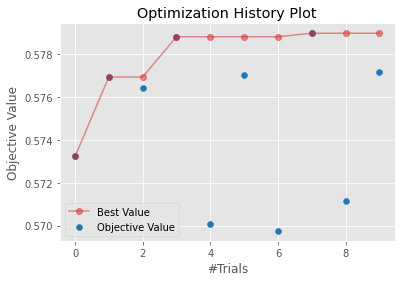

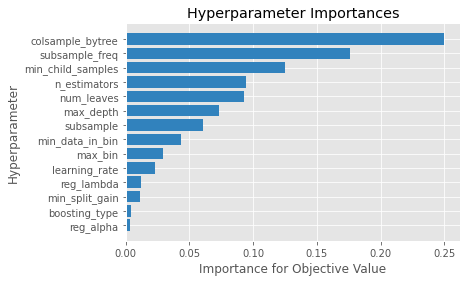

Best score: 0.5789774530204891
ROC-AUC train: 0.6330061696398044
ROC-AUC oot: 0.629975999475366
Saved target_more_0.01_in_2_quart_along model
Tuning target_more_0.01_in_4_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 185


[I 2022-06-22 13:22:31,656] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 13:24:18,363] Trial 0 finished with value: 0.5812796673302085 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.5812796673302085.
[I 2022-06-22 13:26:33,962] Trial 1 finished with value: 0.5950628400558768 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 1 with value: 0.595

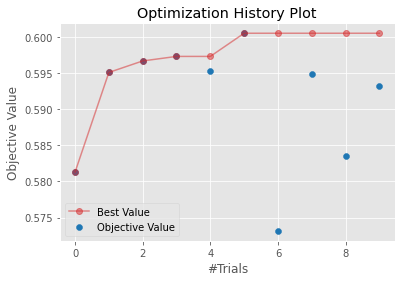

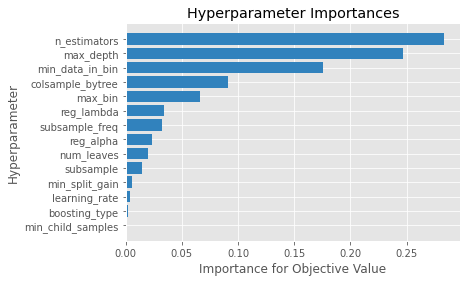

Best score: 0.6004818894220834
ROC-AUC train: 0.9423481739462892
ROC-AUC oot: 0.627893786068491
Saved target_more_0.01_in_4_quart_along model
Tuning target_more_0.01_in_6_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 189


[I 2022-06-22 14:03:31,780] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 14:05:14,620] Trial 0 finished with value: 0.6074455811617017 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.6074455811617017.
[I 2022-06-22 14:07:29,882] Trial 1 finished with value: 0.6353121936948566 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 1 with value: 0.635

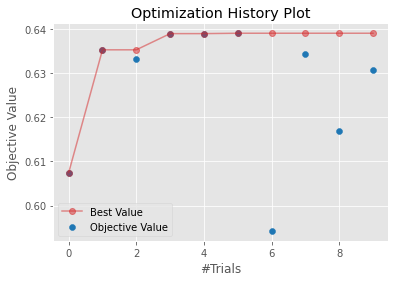

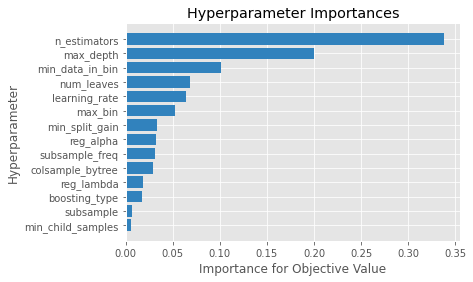

Best score: 0.639068716436099
ROC-AUC train: 0.9710708322269385
ROC-AUC oot: 0.6204407702367134
Saved target_more_0.01_in_6_quart_along model
Tuning target_more_0.05_in_1_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 181


[I 2022-06-22 14:46:44,273] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 14:48:34,565] Trial 0 finished with value: 0.5698986065067407 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.5698986065067407.
[I 2022-06-22 14:50:50,352] Trial 1 finished with value: 0.5820620525213637 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 1 with value: 0.582

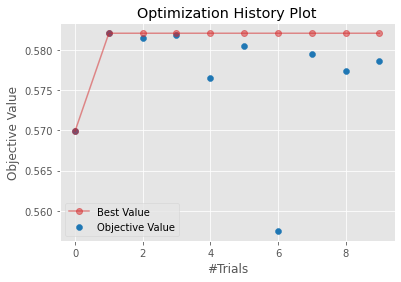

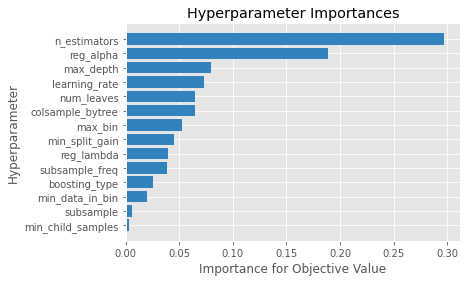

Best score: 0.5820620525213637
ROC-AUC train: 0.6744494900917527
ROC-AUC oot: 0.6662858456680945
Saved target_more_0.05_in_1_quart_along model
Tuning target_more_0.05_in_2_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 186


[I 2022-06-22 15:28:39,318] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 15:30:31,668] Trial 0 finished with value: 0.5806120390199985 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.5806120390199985.
[I 2022-06-22 15:32:47,561] Trial 1 finished with value: 0.5964483975490343 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 1 with value: 0.596

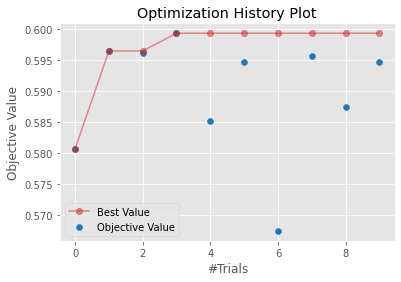

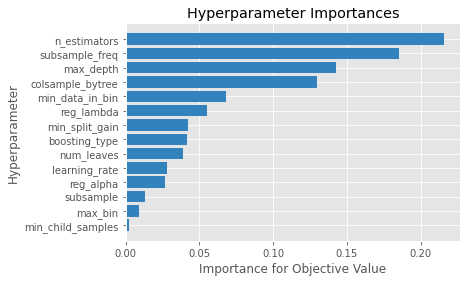

Best score: 0.5993111640595636
ROC-AUC train: 0.6611337367410536
ROC-AUC oot: 0.601987501331521
Saved target_more_0.05_in_2_quart_along model
Tuning target_more_0.05_in_4_quart_along model
Start select features by correlation


  0%|          | 0/705 [00:00<?, ?it/s]

Start select features by score


  0%|          | 0/705 [00:00<?, ?it/s]

Отобрано признаков: 183


[I 2022-06-22 16:14:01,756] A new study created in memory with name: LGBM Classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-06-22 16:15:49,656] Trial 0 finished with value: 0.6194383815350484 and parameters: {'min_child_samples': 11, 'min_data_in_bin': 195, 'min_split_gain': 1.31, 'max_depth': 2, 'n_estimators': 266, 'learning_rate': 0.009216956935682395, 'boosting_type': 'dart', 'reg_alpha': 9.827419145614721, 'reg_lambda': 6.356607351611918, 'num_leaves': 57, 'colsample_bytree': 0.7294164592505679, 'subsample': 0.7273359748055357, 'subsample_freq': 2, 'max_bin': 57}. Best is trial 0 with value: 0.6194383815350484.
[I 2022-06-22 16:18:01,706] Trial 1 finished with value: 0.6323323313545709 and parameters: {'min_child_samples': 51, 'min_data_in_bin': 39, 'min_split_gain': 2.71, 'max_depth': 4, 'n_estimators': 444, 'learning_rate': 0.0379197884844309, 'boosting_type': 'gbdt', 'reg_alpha': 6.0803430345942004, 'reg_lambda': 6.152320369708368, 'num_leaves': 165, 'colsample_bytree': 0.5610901042782008, 'subsample': 0.850093689161936, 'subsample_freq': 3, 'max_bin': 190}. Best is trial 1 with value: 0.632

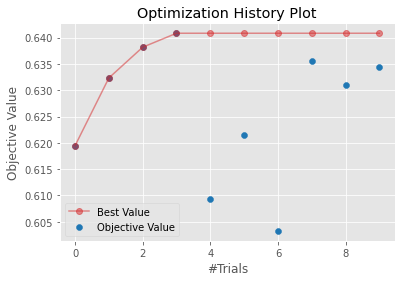

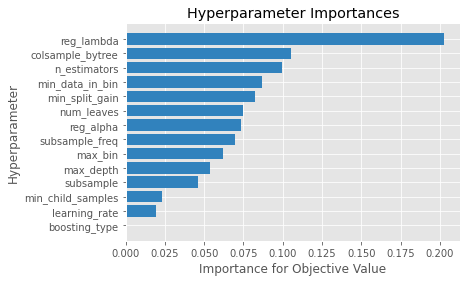

Best score: 0.6408390600235137
ROC-AUC train: 0.7581747880401215
ROC-AUC oot: 0.6405232211402918
Saved target_more_0.05_in_4_quart_along model


In [ ]:
fit_and_save_models(df_gross)

In [1]:
# best_params_rf = optimize_rf_clf(X_train[features_any], y_train, 10)

In [ ]:
# rf = RandomForestClassifier(**best_params_rf)
# rf.fit(X_train[features_any], y_train)

In [ ]:
y_pred = model1.predict_proba(X_oot[features_any])[:,1]
plt.hist(y_pred)

In [ ]:
y_pred.mean(), y_oot.mean(), y_train.mean()

In [ ]:
bin_pred = np.where(y_pred > 0.45, 1, 0)

In [ ]:
confusion_matrix(y_oot, bin_pred)

array([[8658,  893],
       [2209,  263]])

In [ ]:
f1_score(y_oot, bin_pred), precision_score(y_oot, bin_pred), recall_score(y_oot, bin_pred)

(0.1449834619625138, 0.22750865051903113, 0.1063915857605178)

In [ ]:
roc_auc_score(y_oot, y_pred)

0.7321008504734906